# Simple Tickets prediction with DNN

**Predicting the number of tickets requested by different clients**

**Supervised Learning. Regression**


Data taken from [Udacity's problem solving with advanced analytics](https://www.udacity.com/course/problem-solving-with-advanced-analytics--ud976)

Here a neural network is effectively appllied in a simple problem usually solved with linear models

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import keras

helper.info_gpu()
helper.reproducible(seed=9) # setup reproducible results from run to run using Keras

%matplotlib inline

Using TensorFlow backend.


/device:GPU:0
Keras		v2.1.3
TensorFlow	v1.4.1


## 1. Data Processing and Exploratory Data Analysis

In [2]:
data_path = 'data/simple_tickets_data.csv'
target = ['Average Number of Tickets']

df = pd.read_csv(data_path)
print("rows: {} \ncolumns: {} \ntarget: {}".format(*df.shape, target))

rows: 300 
columns: 5 
target: ['Average Number of Tickets']


### Show the data

In [3]:
df.head()

,Client ID,Average Number of Tickets,Number of Employees,Value of Contract,Industry
0,TK669,90,561,200000,Retail
1,EY859,85,530,200000,Retail
2,TN571,5,82,25000,Manufacturing
3,LJ675,82,491,225000,Manufacturing
4,KH713,12,230,75000,Services


#### Numerical data

In [4]:
df.describe(percentiles=[0.5])

,Average Number of Tickets,Number of Employees,Value of Contract
count,300.000000,300.000000,300.000000
mean,44.596667,421.120000,142083.333333
std,42.582055,245.465265,72128.947071
min,1.000000,50.000000,25000.000000
50%,28.000000,428.000000,150000.000000
max,207.000000,1116.000000,250000.000000


#### Missing values

In [5]:
helper.missing(df);

No missing values found


### Transform the data

#### Remove irrelevant features

In [6]:
df = df.drop('Client ID', axis='columns')

#### Classify variables

In [7]:
numerical = ['Number of Employees', 'Value of Contract', 'Average Number of Tickets']

df = helper.classify_data(df, target, numerical)

pd.DataFrame(dict(df.dtypes), index=["Type"])[df.columns].head()  # show data types

numerical features:   2
categorical features: 1
target 'Average Number of Tickets': float32


,Number of Employees,Value of Contract,Industry,Average Number of Tickets
Type,float32,float32,category,float32


### Visualize the data

#### Categorical features

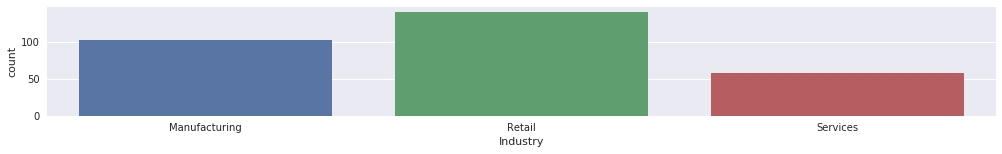

In [8]:
helper.show_categorical(df)

#### Target vs Categorical features

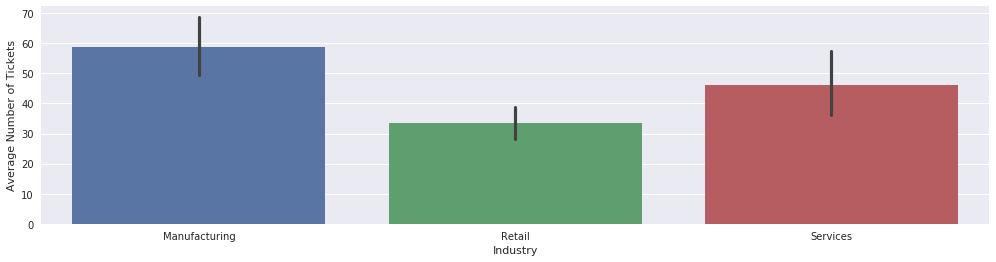

In [9]:
helper.show_target_vs_categorical(df, target)

#### Numerical features

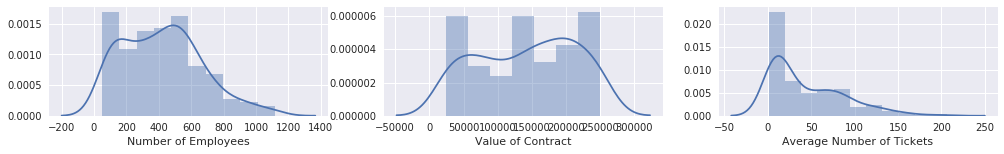

In [10]:
helper.show_numerical(df, kde=True)

#### Target vs Numerical features

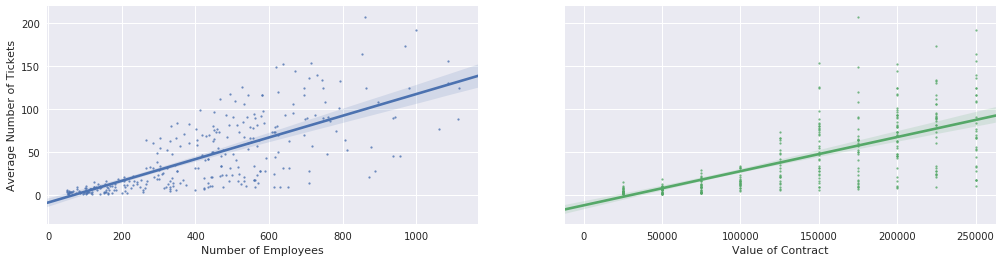

In [11]:
helper.show_target_vs_numerical(df, target, point_size=20)

#### Target vs All features

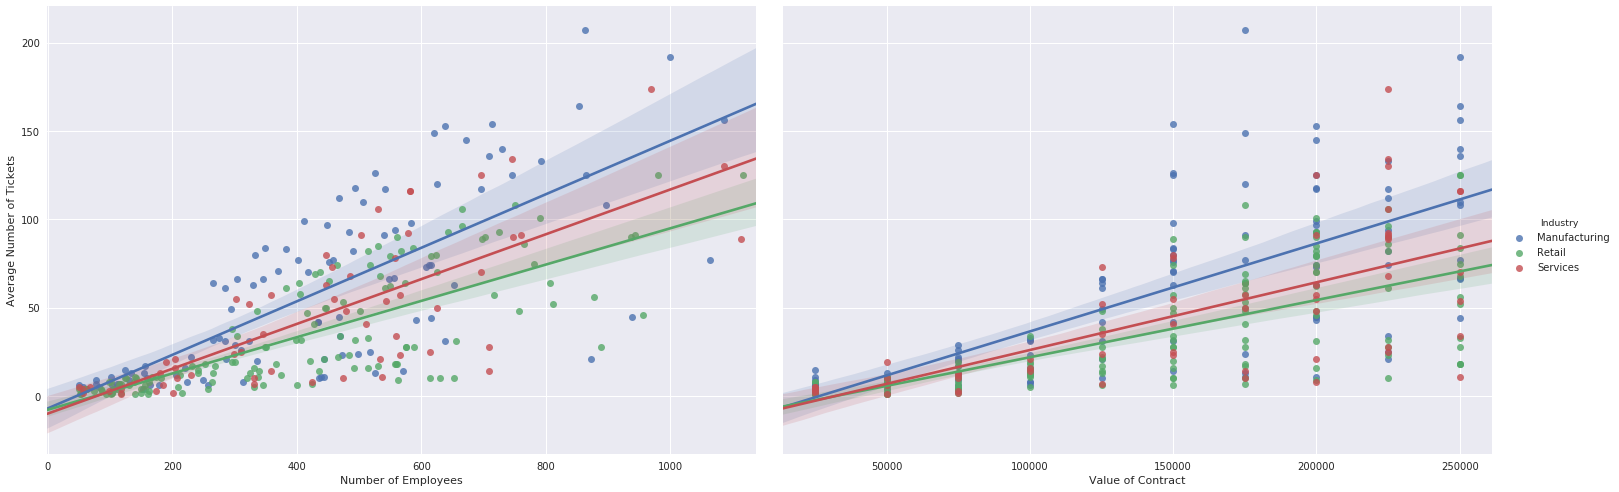

In [12]:
g = sns.PairGrid(df, y_vars=target, x_vars=['Number of Employees', 'Value of Contract'], 
                 size=7, hue='Industry', aspect=1.5)
g.map(sns.regplot).add_legend();

#sns.pairplot(df, hue = 'Industry', vars=['Number of Employees', 'Value of Contract'] + 
#             targets, size = 4)

These figures suggest that a simple linear model could be used to make accurate predictions

#### Correlation between numerical features and target

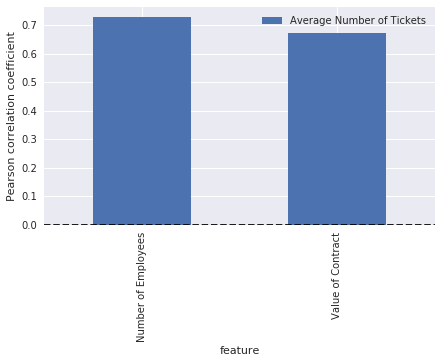

In [13]:
helper.show_correlation(df, target, figsize=(7,4))

## 2. Neural Network model

### Select the features

In [14]:
droplist = []  # features to drop

# For the model 'data' instead of 'df'
data = df.copy()
data.drop(droplist, axis='columns', inplace=True)
data.head(3)

,Number of Employees,Value of Contract,Industry,Average Number of Tickets
0,561.0,200000.0,Retail,90.0
1,530.0,200000.0,Retail,85.0
2,82.0,25000.0,Manufacturing,5.0


### Scale numerical variables
Shift and scale numerical variables to a standard normal distribution. The scaling factors are saved to be used for predictions.

In [15]:
data, scale_param = helper.scale(data)

### Create dummy features
Replace categorical features (no target) with dummy features

In [16]:
data, dict_dummies = helper.replace_by_dummies(data, target)

model_features = [f for f in data if f not in target] # sorted neural network inputs

data.head(3)

,Number of Employees,Value of Contract,Average Number of Tickets,Industry_Manufacturing,Industry_Retail,Industry_Services
0,0.569857,0.80296,1.066255,0,1,0
1,0.443566,0.80296,0.948835,0,1,0
2,-1.381540,-1.62325,-0.929891,1,0,0


### Split the data into training and test set

Data leakage: Test set hidden when training the model, but seen when preprocessing the dataset

No validation set will be used here (300 samples)

In [17]:
test_size = 0.2
random_state = 0

from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=test_size, random_state=random_state)

# Separate the data into features and target (x=features, y=target)
x_train, y_train = train.drop(target, axis=1).values, train[target].values
x_test, y_test = test.drop(target, axis=1).values, test[target].values

One-hot encode the output not needed for regression

In [18]:
print("train size \t X:{} \t Y:{}".format(x_train.shape, y_train.shape))
print("test size  \t X:{} \t Y:{} ".format(x_test.shape, y_test.shape))

train size 	 X:(240, 5) 	 Y:(240, 1)
test size  	 X:(60, 5) 	 Y:(60, 1) 


### Build the Neural Network for Regression  

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout


def build_nn(input_size, output_size, summary=False):

    input_nodes = input_size
    weights = keras.initializers.RandomNormal(stddev=0.001)

    model = Sequential()
    model.add(
        Dense(
            input_nodes,
            input_dim=input_size,
            activation='tanh',
            kernel_initializer=weights,
            bias_initializer=weights))

    model.add(Dense(1, activation=None, kernel_initializer=weights, bias_initializer=weights))

    model.compile(loss='mean_squared_error', optimizer='adam')

    if summary:
        model.summary()

    return model

### Train the Neural Network

Training ....
time: 	 1.4 s


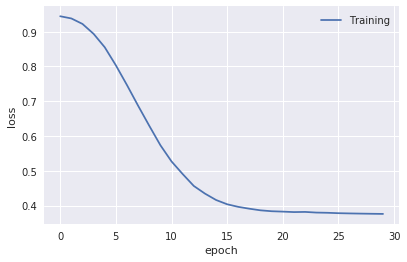


Training loss:  	0.3762

Model saved at models/simple_tickets.h5
Training   R2-score: 	0.603


In [20]:
from time import time
model_path = os.path.join("models", "simple_tickets.h5")


def train_nn(model, x_train, y_train, validation_data=None, path=False, show=True):
    """ 
    Train the neural network model. If no validation_datais provided, a split for validation
    will be used
    """

    if show:
        print('Training ....')

    #callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0)]
    t0 = time()

    history = model.fit(
        x_train,
        y_train,
        epochs=30,
        batch_size=16,
        validation_split=0,
        validation_data=validation_data,
        callbacks=None,
        verbose=0)

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)

    if path:
        model.save(path)
        print("\nModel saved at", path)

    return history


model = None
model = build_nn(x_train.shape[1], y_train.shape[1], summary=False)
train_nn(model, x_train, y_train, validation_data=None, path=model_path);

from sklearn.metrics import r2_score

ypred_train = model.predict(x_train)
#ypred_val = model.predict(x_val)
print('Training   R2-score: \t{:.3f}'.format(r2_score(y_train, ypred_train)))
#print('Validation R2-score: \t{:.3f}'.format(r2_score(y_val, ypred_val)))

### Evaluate the model

In [21]:
# model = keras.models.load_model(model_path)
# print("Model loaded:", model_path)


def evaluate_nn(model, x_test, y_test):
    
    score = model.evaluate(x_test, y_test, verbose=0)
    print("\nTest loss:\t\t{:.4f}".format(score))

    ypred_test = model.predict(x_test)
    print('\nTest R2-score: \t\t{:.3f}'.format(r2_score(y_test, ypred_test)))

evaluate_nn(model, x_test, y_test)


Test loss:		0.6103

Test R2-score: 		0.493


### Make predictions

Average Number of Tickets . Prediction error:
Mean: 	 76.35%
Stddev:  200.50%


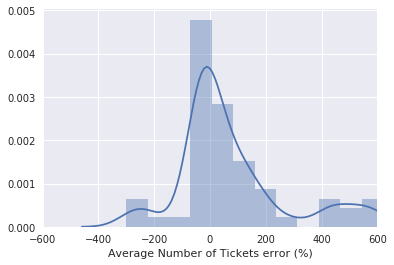

In [22]:
def predict_nn(model, x_test, target):
    """ Return a dataframe with actual and predicted targets in original scale"""

    for t in target:
        pred = model.predict(x_test, verbose=0)
        restore_pred = pred * scale_param[t][1] + scale_param[t][0]
        restore_pred = restore_pred.round()

        restore_y = y_test * scale_param[t][1] + scale_param[t][0]
        restore_y = restore_y.round()

        pred_label = 'Predicted_' + t
        error_label = t + ' error (%)'

        pred_df = pd.DataFrame({
            t: np.squeeze(restore_y),
            pred_label: np.squeeze(restore_pred)
        })

        pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

        print(t, ". Prediction error:")
        print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
        print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
        sns.distplot(pred_df[error_label])
        plt.xlim(xmin=-600, xmax=600)

    return pred_df


pred_df = predict_nn(model, x_test, target)

In [23]:
pred_df.head()

,Average Number of Tickets,Predicted_Average Number of Tickets,Average Number of Tickets error (%)
0,56.0,90.0,60.700001
1,9.0,29.0,222.199997
2,32.0,35.0,9.400000
3,34.0,27.0,-20.600000
4,50.0,64.0,28.000000


The prediction error (%) can be especially high when the number of tickets is low. The absolute error could be a better indicator here. 

### Compare with linear regression

Average Number of Tickets . Prediction error:
Mean: 	 85.51%
Stddev:  214.45%


(-600, 600)

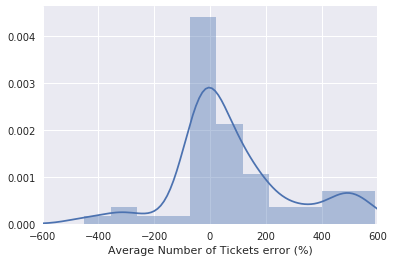

In [24]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(x_train, y_train)
pred = reg.predict(x_test)

t=target[0]
restore_pred = pred * scale_param[t][1] + scale_param[t][0]
restore_pred = restore_pred.round()

restore_y = y_test * scale_param[t][1] + scale_param[t][0]
restore_y = restore_y.round()

pred_label = 'Predicted_' + t
error_label = t + ' error (%)'

pred_df = pd.DataFrame({
    t: np.squeeze(restore_y),
    pred_label: np.squeeze(restore_pred)
})

pred_df[error_label] = ((pred_df[pred_label] - pred_df[t]) * 100 / pred_df[t]).round(1)

print(t, ". Prediction error:")
print("Mean: \t {:.2f}%".format(pred_df[error_label].mean()))
print("Stddev:  {:.2f}%".format(pred_df[error_label].std()))
sns.distplot(pred_df[error_label])
plt.xlim(xmin=-600, xmax=600)

The mean and standard deviation of the error is higher with the linear model.

### Compare with classical ML

In [25]:
helper.ml_regression(x_train, y_train[:,0], x_test, y_test[:,0])

Linear
Bayesian Ridge
Decision Tree
KNeighbors
AdaBoost
Random Forest


,Time (s),Test loss,Test R2 score
Bayesian Ridge,0.0,0.622982,0.482503
Linear,0.0,0.624954,0.480864
AdaBoost,0.0,0.693624,0.423822
Random Forest,0.1,0.710892,0.409478
KNeighbors,0.0,0.764439,0.364997
Decision Tree,0.0,0.894821,0.256692
